# 基于用户Pearson相似性的协同过滤推荐算法实现与验证
## Version 1.0：使用字典dict作为存储结构
- Author: 荀镕基 1819660230  2021.11.25

### （1）实现基于Pearson相似度的协同过滤算法
### 1.计算相似性
### 2.选择邻居
### 3.预测

### （2）算法流程小结

- **Step 1：Data Preprocessing**
  
  1. 读入数据：评分数据 ratings、电影数据 item（物品）
  
     - 从评分数据中，提取出用户 id，存入 user 集合
  
  2. 切块分组 （K-fold 交叉验证）
  
     1）使用 "评分记录" 在 ratings 中的行号，作为记录的标识，进行分块
     2）打乱评分记录的元素顺序
  
     > - 10 折交叉验证（分10块）：循环选取每 1 块用于测试，其余的 9 块的用于训练
     > - ratings.csv 中的评分记录，按 userid 从小到大排列，为了避免测试集只有一个用户，所以需要打乱顺序
  
  3. 用户两两配对 (u1, u2) ：用于计算两两用户之间的相似性
  
  

- **Step 2：Calculate the Similarity**

  > 10 折交叉验证（分10块）：循环选取每 1 块用于测试，其余的 9 块的用于训练
  >
  > 以某一种训练、测试分块情况，举例

  1. 数据准备

     1. 存储 "评分矩阵"

        > - 方案一、使用字典存储，key=user_id；value={"i1":3,"i2":4.5;...} 值是另一个字典
        > - 方案二、使用 numpy 矩阵存储

     2. 编写必要函数

        > - 获取某用户评分过物品 set 集合
        > - 获取（user，item）的评分

  2. 实现 "相似度计算" 的公式

     > - Pearson 相似度函数
     > - Cosine 相似度

  3. 计算相似度，存储到"相似度矩阵 similarity"

     > - 方案一、使用字典存储
     >   similarity_dict1={u : {v1: 0.29 , v2:0.8, ...}} 值： {v1:相似度值}字典

  4. 邻居排序：按相似度从大到小，对每个用户的所有邻居排序

     >neighbors：dict，{u:[(nb1,sim),(nb2,sim),...按sim从大到小], ...}

  

- **Step 3：Predict**

  1. 预测公式

  2. 计算训练集内所有用户平均评分

  3. 对 test 块的记录，预测评分

     > 1. 先对邻居初步筛选：选择的邻居，需要对预测的item评过分
     > 2. 在满足条件的邻居集合内，选择 K 个邻居
     > 3. 预测rui，预测结果存入 prediction 字典
     >    key=(user，item)，value=[预测评分，用户真实评分（测试集有真值）]



- **Step 4：Evaluation**

  1. 实现评价指标

     > 1. MAE、RMSE

  2. 绘制对应曲线

  3. 比较不同算法的结果

     - 余弦相似度
     - Pearson相似度
     - 基于物品 / 用户
     

- **Step5：给出某一用户的推荐列表**



---
## 1.Data Preprocessing
- 读入 csv 数据
- 打乱顺序，进行分块(K-fold交叉验证)
- 计算相似性的数据准备
    - 存储评分矩阵（使用字典的方式：{userid:{i1:3; i2:4; ...};...}）
    - 用户两两配对（排列组合：（u1,u2）,(u1,u3)...）

In [1]:
#1. 读入数据(F)
#导入pandas库
import pandas as pd

#1）读取评分数据: columns=[userId  movieId  rating  timestamp]
ratings=pd.read_csv("./ratings.csv") #读入为<class 'pandas.core.frame.DataFrame'>
print(ratings.head(5)) #查看开头5行数据
print(ratings.index,'\n',ratings.columns)#行列索引

#2）读取movies数据: columns=[movieId, title, genres]
items=pd.read_csv("./movies.csv",sep=',',encoding="GBK")
# tips: 含中文字符，utf-8无法解码，查询编码格式为GB2312>>用GBK编码
print(items.head(5))

#3）从评分记录中提取用户id,电影id，并存储用户
users=set(ratings['userId']) #用集合来去重，获取用户id
movies=list(items["movieId"]) #下标对应DataFrame中的行号
print(f"=================\n",\
      f"用户个数= {len(users)}, 电影个数={len(movies)}")

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
RangeIndex(start=0, stop=100836, step=1) 
 Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
 用户个数= 610, 电影个数=9742


### 测试代码：测试 pandas 模块功能

In [2]:
# # Q: read_csv()编码格式引发异常 --》获取movies.csv 编码格式
# # UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 28-29
# import chardet
# def print_encoding(filename):
#     with open(filename,'rb') as fp:
#         print(chardet.detect(fp.read()))

# print_encoding('./movies.csv')

In [2]:
# 测试：pandas.DataFrame.query() 查询操作
# 1.查询1个元素
search_movieId=1
search_result=items.query("movieId == @search_movieId") #<class 'pandas.core.frame.DataFrame'>
print(search_result,type(search_result))
print(f"search_result.empty={search_result.empty}")
movieName_tmp=list(search_result.loc[:,"title"])[0] #提取出 Series 变量中指定元素
print(movieName_tmp,type(movieName_tmp))

# 2.查询多个元素
# search_movieId=[1,99999,103]
# search_result=items.query("movieId in @search_movieId") #<class 'pandas.core.frame.DataFrame'>
# print(search_result,type(search_result))
# print(list(search_result.loc[:,"title"]),type(search_result.loc[:,"title"]))


   movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy <class 'pandas.core.frame.DataFrame'>
search_result.empty=False
Toy Story (1995) <class 'str'>


In [3]:
#测试
u=ratings.loc[90096,:] # 返回 Series 类型
# u.loc['userId']
print(f"{u}\n\n userId={int(u['userId'])},movieId={int(u['movieId'])},",\
      f"rating={u['rating']}") # 行索引方式访问
print(int(u[0]),int(u[1]),u[2],u.name) #下标方式访问

userId       5.860000e+02
movieId      2.268000e+03
rating       3.500000e+00
timestamp    1.529900e+09
Name: 90096, dtype: float64

 userId=586,movieId=2268, rating=3.5
586 2268 3.5 90096


In [4]:
# 测试：itertuples
for rows in ratings.loc[0:3,['userId','movieId']].itertuples():
    print(rows, type(rows), rows.Index)
    
print(f"ratings.shape={ratings.shape},type={type(ratings.shape)}")
print(ratings.iloc[[1,3,5],:],type(ratings.iloc[1,:]))

Pandas(Index=0, userId=1, movieId=1) <class 'pandas.core.frame.Pandas'> 0
Pandas(Index=1, userId=1, movieId=3) <class 'pandas.core.frame.Pandas'> 1
Pandas(Index=2, userId=1, movieId=6) <class 'pandas.core.frame.Pandas'> 2
Pandas(Index=3, userId=1, movieId=47) <class 'pandas.core.frame.Pandas'> 3
ratings.shape=(100836, 4),type=<class 'tuple'>
   userId  movieId  rating  timestamp
1       1        3     4.0  964981247
3       1       47     5.0  964983815
5       1       70     3.0  964982400 <class 'pandas.core.series.Series'>


---

In [5]:
#2. 切块分组(I)
import random
import math
# 分块：方案一、提取出评分记录中（userid, movieid)
# rating_index_set=[(i[1],i[2],i.Index) for i in (ratings.loc[:,['userId','movieId']].itertuples())]
# print(max(rating_index_set))
# 方案二、直接使用记录在 ratings 里的行号
rating_index_set=list(range(ratings.shape[0]))

#打乱列表元素顺序
# csv文件中数据,按 userid 从小到大排列
# K折交叉验证前90%训练、后10%测试，所以需要打乱顺序
random.seed(5) # 设置随机种子，使得每次运行程序的结果相同
random.shuffle(rating_index_set) 
# print(rating_index_set[0:20])

#----------------------------
# K 折交叉验证
K_fold_num=10; # 10折，分10块
#一共有m块，自动分（尽可能平均）
#split the arr into N chunks
def chunks(arr, m):
    n = int(math.ceil(len(arr) / float(m))) # 每块多少个记录
    return [arr[i:i + n] for i in range(0, len(arr), n)]

folds=chunks(rating_index_set,K_fold_num)
for i in folds:
    print(len(i),i[0:4]) #观察每块的记录数量，前4条记录的下标
#----------------------------
# folds=folds

#3. 确定邻居数量(G)
neighbor_num_list=[1,5,10,15,20,25,30,35,40,45,50,55,60]
K_neighbor_num = neighbor_num_list[8] # number of neighbors

10084 [52655, 4327, 81078, 40693]
10084 [83652, 83548, 100178, 14796]
10084 [26586, 75990, 21643, 77376]
10084 [64905, 63504, 63397, 24322]
10084 [29816, 37509, 95806, 44211]
10084 [18682, 50467, 98082, 17671]
10084 [78108, 14985, 31861, 93673]
10084 [47076, 81071, 84024, 33009]
10084 [19080, 20646, 24676, 75577]
10080 [47317, 23637, 55169, 92646]


#itertools.combination([1,2,3])

In [6]:
#4. 用户两两配对(D)
import itertools

# pairs=[i for i in itertools.combinations(users,2)] 
pairs=list(itertools.combinations(users,2)) # 返回所有长度r=2 的子序列（users: 用户id集合）
for i in pairs[600:620]:
    print(i)

(1, 602)
(1, 603)
(1, 604)
(1, 605)
(1, 606)
(1, 607)
(1, 608)
(1, 609)
(1, 610)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)


# 注：仅用循环的一次情况，来验证代码
---
#  用户，物品，评分索引(E)
# let us make index
- 建立 {用户：{物品：评分}} 的映射
## 10 折交叉验证：9块 train ，1块 test
- （循环10次，每块分别做一次test)


In [7]:
# 使用train分块，来存入评分矩阵，作为已有数据（test块的数据，认为未知，从而预测验证）
test_fold_num=0
if test_fold_num >= K_fold_num or test_fold_num<0:
    raise Exception("test_fold 分块下标越界！")

import time
# Q:如何存储评分矩阵？

def get_rating_matrix(K_fold_num:int,test_fold_num:int,ratings:dict,folds:list,
                      select_all_folds:bool=False)->dict:
    """
    评分矩阵
    方案一、使用字典存储：key=user_id；value={"i1":3,"i2":4.5;...} 值是另一个字典
    传入
    K_fold_num:int，K折（总分块数）
    test_fold_num:int,（test块的编号,0~K_fold_num-1）
    ratings:dict,原始评分记录（u,item,rui)
    folds:list 每一块中数据的行号（DataFrame）集合
    select_all_folds:bool 是否选择全部数据，加入评分矩阵
    返回
    dict_uir：{u:{v1:3,v2:2,...}} #基于用户的协同过滤 CF
    dict_iur：{i:{u1:3,u2:4,...}} #基于物品的 CF
    """
    dict_uir={} #基于用户的协同过滤 CF
    dict_iur={} #基于物品的 CF

    # start_time=time.mktime(time.gmtime())
    for train_fold_index in range(K_fold_num):
        if train_fold_index == test_fold_num and not select_all_folds:
            continue

        #每一块内，存储记录对应在 DataFrame 的下标
        record_index=folds[train_fold_index]
        for record_series in ratings.iloc[record_index,:].itertuples():
            # 此种方式先从Dataframe里1次就读出来全部要的(0.0s），较每次去读一个（15s)更快
            index_=record_series.Index
            user=int(record_series.userId)
            item=int(record_series.movieId)
            rating=record_series.rating
            
            #1.基于用户的字典（评分矩阵）
            if user in dict_uir:
                # 加入新的物品评分
                d=dict_uir[user]
                d[item]=rating     
            else:
                # 加入新的用户
                d={item:rating}
                dict_uir[user]=d
                
            #2.基于物品的字典（评分矩阵）
            if item in dict_iur:
                d=dict_iur[item]
                d[user]=rating
            else:
                d={user:rating}
                dict_iur[item]=d
                
                
#     print(f"用时 {time.mktime(time.gmtime())-start_time} s")
    return [dict_uir,dict_iur]


dict_uir,dict_iur=get_rating_matrix(K_fold_num,test_fold_num,ratings,folds)
# # 测试
# print(dict_uir[1])

In [8]:
# 6. 获取某用户评分过物品的函数(B)
def getItemsBy (dict_uir:dict,user:int) -> dict:
    """获取指定用户，评过分的物品的 set 集合"""
    if user in dict_uir:
        return set(dict_uir[user].keys()) 
        #返回 set 集合（便于取交集，并集）
    else:
        return None
#         raise Exception("没有此用户！")

In [9]:
# # 测试
# getItemsBy(dict_uir,1)

In [10]:
# 7. 获取user item，的评分(A)
def getRating(dict_uir:dict,user:int,item:int)->float:
    """返回 用户对某物品的评分
    参数：dict 为函数注解，python 不做强制检查
    """
    if user in dict_uir:
        if item in dict_uir[user]:
            return dict_uir[user][item]
        else :
            None #user用户未对item物品评过分
    else:
        None #未知用户（train数据中，没有这个用户的评分记录）

In [11]:
# 测试
getRating(dict_uir,1,1)

4.0

# 2.similarity calculation
## 2-1 相似度函数

In [12]:
#1. 计算皮尔逊相似性函数(C)
#import numpy as np
import math
def cal_pccs(x, y):
    """
    计算 Pearson 相关性系数
    warning: data format must be narray
    :param x: 用户1的（两用户共同物品的）评分 list 列表
    :param y: 用户2的评分列表
    :param n: The number of elements in x
    :return: pccs
    """
    modify_C=0.0001; #避免Pearson公式分母==0，加上一个常数项
    
    n1=len(x)
    n2=len(y)
    if n1!=n2 or n1 == 0 or n2 == 0:
        return None
    else:
        ave_x=   sum(x) / len (x) # np.average(x)
        ave_y=  sum(y) / len (y) # np.average(y)
        x_num = [i - ave_x  for i in x]
        y_num = [i - ave_y  for i in y]
        num=[x*y for (x,y) in list(zip(x_num,y_num))]
        num_sum= sum(num) # Pearson相关性的分子
        
        x_den = [i * i  for i in x_num]
        y_den = [i * i  for i in y_num]
        den=math.sqrt(sum(x_den)*sum(y_den))+modify_C # Pearson 分母          
        if den==0.0:
            return None 
        else :
            return num_sum/den        

In [13]:
#2.计算余弦相似度
def cal_CosineSimilarity(x, y):
    """
    计算 Cosine 相关度
    :param x: 用户1的（两用户共同物品的）评分 list 列表
    :param y: 用户2的评分列表
    :return: pccs
    """
    n1=len(x)
    n2=len(y)
    if n1!=n2 or n1 == 0 or n2 == 0:
        return None
    
    modify_C=0.0001; #避免公式分母==0，加上一个常数项
    
    cos_nominator=sum([x[i]*y[i] for i in range(len(x))])
    x_norm=sum([i**2 for i in x])**0.5
    y_norm=sum([i**2 for i in y])**0.5
    
    cosine_sim=cos_nominator/(x_norm*y_norm+modify_C)
    
    return cosine_sim

In [12]:
# # 测试：Python中将函数，作为另一个函数的参数，传入并调用
# def test_sim(sim_func_name="Pearson"):
#     sim_func_dict={"Pearson":cal_pccs,"Cosine":cal_CosineSimilarity}
#     func_sim=sim_func_dict.get(sim_func_name,f"Key Error:未定义函数={sim_func_name}")
#     if type(func_sim)==str:
#         raise Exception(f"Dict Key Error:未定义函数={sim_func_name}")
    
#     print(type(func_sim),func_sim)
#     x=[5,4.5,3,4]
#     y=[1,2,3,4]
#     print(func_sim(x,y))
    
# test_sim(sim_func_name="Pearson")

## 2-2计算相似度，并存储到“相似度矩阵”

In [14]:
# 2. 按照配对计算相似性，保存起来(E)
sim_func_dict={"Pearson":cal_pccs,"Cosine":cal_CosineSimilarity}

# Q:存储相似性 
def get_similarity(dict_uir, pairs:"配对元组",
                   sim_func_name:str="Pearson",
                   sim_func_dict:dict=sim_func_dict)->dict:
    """
    获取相似度矩阵（或字典）
    方案一、存在字典：similarity_dict1={u : {v1: 0.29 , v2:0.8, ...}} 值： {v1:相似度值}字典
    :param sim_func_name: 选择哪种相似度计算公式
    :param sim_func_dict: 将计算相似度函数的函数名，存入字典供选择调用
    """
    similarity={}
    # 选择相似度计算公式
    sim_func=sim_func_dict.get(sim_func_name,f"Key Error:未定义函数={sim_func_name}")
    if type(sim_func)==str:
        raise Exception(f"Dict Key Error:未定义函数={sim_func_name}")

    for (u,v) in pairs:
        #print(u,v)

        # 1）获取用户u、v共同评过分的物品集合
        items_by_u = getItemsBy(dict_uir,u) #获取用户u的物品 set 集合
        items_by_v = getItemsBy(dict_uir,v) # 用户v的物品

        if len(items_by_u) >0 and len(items_by_v) >0:        
            intersected = items_by_u.intersection(items_by_v) # 集合取并集

            if len(intersected)>0:
                # 有共同评过分的物品
                ratings_u = [getRating(dict_uir,u,i) for i in intersected] #共同物品的评分列表
                ratings_v = [getRating(dict_uir,v,i) for i in intersected]
                #print(len(ratings_u),len(ratings_v))

                # TODO: 什么情况需要 == None
                if ratings_u !=None and ratings_v !=None:       
                    # 计算相似性
                    #s=np.corrcoef(ratings_u,ratings_u)                   
                    s = sim_func(ratings_u,ratings_v)
                    if s==None or math.isnan(s):
                        #  当一个用户所有评分==均值时候，分母算出来=0
                        print(f"用户id={u}和id={v}, {sim_func_name}相似性分母==0!!!!!!!\n")
                    else:
                        # 正常计算出来 Pearson 相似度,在 相似度矩阵中均存下来
                        if u in similarity:
                            similarity[u][v]=s
                        else :
                            d={v:s}  
                            similarity[u]=d

                        if v in similarity:
                            similarity[v][u]=s # 加similarity[v][u]的相似度
                        else :
                            d={u:s}  
                            similarity[v]=d  

                else: () 
            else:
                ()
        else:
            ()
    return similarity
        
similarity=get_similarity(dict_uir,pairs,
                          sim_func_name="Pearson",
                          sim_func_dict=sim_func_dict
                         )
print(similarity[1])

{2: 0.0, 3: 0.0, 4: 0.08273764109117288, 5: 0.5631698028842356, 6: -0.42666020370789687, 7: -0.2164747598351331, 8: 0.5903326000567504, 9: 0.9185117809356496, 10: -0.522959266910114, 11: 0.0, 12: 0.0, 13: 0.8782586400934237, 14: 0.2539819054450136, 15: 0.43225822638040295, 16: 0.07477251431271911, 17: 0.12525348480930157, 18: 0.29285829546470576, 19: 0.30498545305623503, 20: 0.40838373327305616, 21: 0.24877823717690908, 22: -0.3356640928271952, 23: -0.7619827900747931, 24: 0.29104929693000114, 25: 0.0, 26: 0.4999625028122891, 27: 0.3815351506810615, 28: 0.09088117877174624, 29: -0.28156071872992694, 30: 0.0, 31: -0.03478353058270311, 32: 0.3737215688369123, 33: 0.10430072015024883, 34: 0.12697743326531097, 35: 0.29879822402895395, 36: 0.4381993365339904, 37: -0.2691793573255314, 38: 0.43738476522044173, 39: -0.1739174283526224, 40: -0.4154354613006749, 41: 0.10634304465215423, 42: 0.2590576938685779, 43: -0.024195045218462722, 44: 0.6876759947942676, 45: 0.3453079780962903, 46: 0.04166

In [12]:
"""改进:Python进程池，提高运行速度"""
# from multiprocessing import Pool
# pool = Pool()
# def Test(a,b):
#     return(a,b,a+b)

# data=[(1,2),(3,4),(1,2),(3,4),(1,2),(3,4),(1,2),(3,4),(1,2),(3,4),(1,2),(3,4),(1,2),(3,4),(1,2),(3,4)]
# pool.map(Test,data)

'改进:Python进程池，提高运行速度'

In [15]:
# 10. 邻居排序(J)
# neighbor selection
def sorted_neighbors(similarity:dict):
    """
    邻居排序(按相似度从大到小)
    传入
    similarity:dict
    返回
    neighbors：dict，{u:[(v1,Suv1),...],...}
    """
    neighbors = {} #{u:[(nb1,sim),(nb2,sim),...按sim从大到小], ...}
    for s in similarity:
        # s为 similarity 字典的键值
        # 注：similarity为{u:{v1：Sim(u,v1), v2:Sim(u,v2),...}}
        neigh=similarity[s]
        r=[(k,neigh[k]) for k in neigh] # 邻居的id、相似度
        r=sorted(r,key=lambda i:i[1],reverse=True) # 从大到小排
    #     print(r)
        neighbors[s] = r
    return neighbors

neighbors=sorted_neighbors(similarity)
print(neighbors[1][1:20])

[(342, 0.9999625014061971), (146, 0.9999555575307764), (481, 0.9999500024998749), (421, 0.9999333377774815), (106, 0.9998666844420744), (238, 0.9998000399920016), (285, 0.9998000399920016), (511, 0.9997500624843794), (550, 0.9997000899730081), (473, 0.970698421063919), (9, 0.9185117809356496), (13, 0.8782586400934237), (366, 0.8727763332389259), (99, 0.8660004045061056), (154, 0.8659754066710234), (375, 0.8439473224994407), (431, 0.8401092310055767), (344, 0.8399462797158506), (90, 0.8215613368739202)]


In [16]:
# 3. 定义邻居数据单元(I)

class NeighborInfo():    
    def __init__(self,neighbor_id,rating_on_target,similarity):
        self.Neighbor_id=neighbor_id
        self.Rating=rating_on_target
        self.Similarity=similarity
        
    

## Predict 评分

In [17]:
# 1. 预测公式
# 注：预测某一个物品，要重新求一个邻居列表。
#   邻居是有条件的：对物品i评过分，再通过相似度排序选K个
def predict(user_average_rating_dict:dict,target_user:int,neighbors:list,
           merely_average_pred_flag:bool=False)->float:
    """
    预测用户id=target_user, 对某物品的评分（物品id隐含在neighbors中）
    :param user_average_rating_dict: key=ueserid,value= 此用户的评分均值
    :param target_user: 预测用户
    :param neighbors：针对物品的邻居list（元素为class NeighborInfo的实例）
    :param merely_average_pred_flag:bool=False：是否直接将用户的平均评分，作为预测评分（默认False）
    """
    ave_u  = 3.5 #新用户（无任何评分）
    if target_user in user_average_rating_dict:
        ave_u = user_average_rating_dict[target_user]
        
    if merely_average_pred_flag:
        # 直接用均值作为预测评分
        return ave_u
    
    numerator=0.0
    denominator =0.0
    for n in neighbors:
        ave_v=3.5
        if n.Neighbor_id in user_average_rating_dict:
            ave_v=user_average_rating_dict[n.Neighbor_id] 
        numerator +=(n.Rating - ave_v) * n.Similarity
        denominator += math.fabs(n.Similarity)
    r = 0.0 
    if denominator!=0.0:
        r=numerator/denominator
    if math.isnan(r) :
        return ave_u
    else:
        return (ave_u + r)

In [18]:
# 2. 计算训练集内所有用户平均评分(A)
def Average_Rating_training(dict_train_uir:dict)->dict:
    """
    统计训练集内，每个用户的评分均值
    :param dict_train_uir: 训练集数据评分矩阵（字典）
    :return: 评分均值的字典 {user_id: average_rating}
    """
    ave_rating_dict={}
    for u in dict_uir:
        # user一定有评分才会存入dict_uir

        ir=dict_uir[u].values()
        ave=sum(ir )/len(ir)
        ave_rating_dict[u]=ave
    return ave_rating_dict

ave_rating=Average_Rating_training(dict_uir)
print(ave_rating[1])

4.3619047619047615


In [19]:
#3. 对 test 块的记录，预测评分(L)
def test_fold_predict(test_fold_num:int,K_neighbor_num:int,
                      folds:list,ratings:"pandas.DataFrame",
                      dict_uir:dict,neighbors:dict,
                      ave_rating:dict,
                      print_true:bool=False,
                      merely_average_pred_flag:bool=False
                     ):
    """ 对 test 块的记录，预测评分 （train块的数据，作为评分矩阵中已知数据）
    传入：
    test_fold_num：K折交叉验证中，选的test块编号
    K_neighbor_num：邻居个数
    ratings：原始评分记录（u,item,rating),pandas.DataFrame
    dict_uir：评分矩阵，使用字典存储{u:{v1:3.5,v2:4,...}}
    neighbors：每个用户的邻居(有共同评分的物品) {u:[(v1,Suv1),(v2,Suv2)...]}
    print_true:bool 是否打应显示每个记录的预测结果
    merely_average_pred_flag:bool=False 是否直接用用户评分均值，作为预测评分
    返回：
    prediction：{（u,i):[pred_rating,actual_rating]...}
    """
    prediction={}
    print("--"*20)
    print(f"test predict: test块编号={test_fold_num};邻居个数={K_neighbor_num}")
    test_StartTime=time.mktime(time.gmtime()) #显示测试时间
    
    test_index_list=folds[test_fold_num]
    for test_record_tuple in ratings.iloc[test_index_list].itertuples():
        
        user=test_record_tuple.userId
        item=test_record_tuple.movieId
        actual_rating=test_record_tuple.rating
        
        
        if  merely_average_pred_flag:
            # 直接将用户均值（训练集合）作为预测评分
            predicted = predict(ave_rating,user,[],merely_average_pred_flag=True)
            
        else:
    
            # 根据预测公式 rui=rui_avg+...预测评分
            #1）先对邻居初步筛选：选择的邻居，需要对预测的item评过分
            result=[]      
            if user in neighbors:
                for (user2,sim) in neighbors[user]:
                    if (user2 in dict_uir) and item in dict_uir[user2]: 
                        # 选择的邻居，需要对预测的item评过分
                        result.append((user2,sim))
            else:
                #和其他用户没有共同评过分的物品（自己没评过分、或没有共同评过的）
                print(f"user_id={user}, is not in neighbors and has not comment on the items that others have commented!...") 


            #2）在满足条件的邻居集合内，选择 K 个邻居
            result2=[]
            for (user2,sim) in result:
                n = NeighborInfo(user2,dict_uir[user2][item],sim) 
                # 实例变量（userId, 真实评分，相似度）
                result2.append(n)
            #选择前面K个，不足K个选择全部（已经按相似度从大到小排好）
            neighbor_select_result=result2[0:K_neighbor_num]


            #3）预测rui
            predicted = predict(ave_rating,user,neighbor_select_result,
                                merely_average_pred_flag=False)
        
        #显示结果
        if print_true:
            print(f"(user,item)={(user,item)},predicted={predicted},actual_rating={actual_rating}")

        prediction[(user,item)]=[predicted,actual_rating]
    
    
    print(f"---test块编号={test_fold_num} costs{time.mktime(time.gmtime())-test_StartTime}s in prediction")
    return prediction
        
        
prediction=test_fold_predict(test_fold_num,K_neighbor_num,
                      folds,ratings,
                      dict_uir,neighbors,ave_rating,
                      print_true=True,
                      merely_average_pred_flag=False)       
        


----------------------------------------
test predict: test块编号=0;邻居个数=40
(user,item)=(345, 32),predicted=4.382680314366329,actual_rating=3.5
(user,item)=(28, 1748),predicted=3.717478247160505,actual_rating=3.5
(user,item)=(513, 5952),predicted=3.887425616011614,actual_rating=3.0
(user,item)=(275, 1296),predicted=4.606463541720858,actual_rating=4.0
(user,item)=(105, 94833),predicted=4.213878897061228,actual_rating=2.5
(user,item)=(346, 7234),predicted=4.570115872895919,actual_rating=3.5
(user,item)=(514, 2003),predicted=3.4509841549510156,actual_rating=4.0
(user,item)=(382, 41566),predicted=3.342450499320883,actual_rating=4.5
(user,item)=(432, 2628),predicted=3.292420411556492,actual_rating=4.0
(user,item)=(108, 5380),predicted=4.4396391815776814,actual_rating=5.0
(user,item)=(137, 2648),predicted=4.496211971118065,actual_rating=3.5
(user,item)=(105, 40815),predicted=4.2142520031241055,actual_rating=3.0
(user,item)=(586, 91630),predicted=4.668015080436926,actual_rating=4.0
(user,item)=(

(user,item)=(266, 2890),predicted=3.4917618673012316,actual_rating=5.0
(user,item)=(606, 480),predicted=3.6656581195137865,actual_rating=2.5
(user,item)=(474, 2186),predicted=4.021246495802548,actual_rating=4.5
(user,item)=(339, 8368),predicted=4.074529797069592,actual_rating=2.5
(user,item)=(39, 1219),predicted=4.145892602367011,actual_rating=5.0
(user,item)=(68, 2605),predicted=2.8660393287293475,actual_rating=3.5
(user,item)=(50, 3221),predicted=2.9825242447865192,actual_rating=3.5
(user,item)=(112, 150),predicted=3.781764041108238,actual_rating=4.0
(user,item)=(477, 55167),predicted=4.853693248949405,actual_rating=4.5
(user,item)=(80, 44974),predicted=3.535186281966621,actual_rating=4.5
(user,item)=(380, 8781),predicted=3.3711857369812366,actual_rating=3.0
(user,item)=(377, 6899),predicted=3.9298245614035086,actual_rating=3.5
(user,item)=(346, 7008),predicted=4.304293225971886,actual_rating=5.0
(user,item)=(4, 222),predicted=3.2665616233400248,actual_rating=1.0
(user,item)=(75, 120

(user,item)=(237, 1371),predicted=3.109993535687145,actual_rating=2.5
(user,item)=(90, 708),predicted=3.9224047072669244,actual_rating=3.0
(user,item)=(265, 3194),predicted=3.5500218123792058,actual_rating=3.0
(user,item)=(414, 2570),predicted=3.4619525659205332,actual_rating=3.0
(user,item)=(292, 41566),predicted=3.463567051685389,actual_rating=3.5
(user,item)=(105, 1293),predicted=4.187253648731737,actual_rating=4.0
(user,item)=(610, 27801),predicted=4.168755377600214,actual_rating=4.5
(user,item)=(112, 288),predicted=3.2476291603446428,actual_rating=4.0
(user,item)=(312, 2641),predicted=3.4274871729800207,actual_rating=3.0
(user,item)=(249, 8641),predicted=3.9109028531843935,actual_rating=4.5
(user,item)=(226, 1639),predicted=3.6924373213821617,actual_rating=3.0
(user,item)=(23, 1274),predicted=3.7751563751364565,actual_rating=4.0
(user,item)=(317, 589),predicted=3.962991582976981,actual_rating=4.0
(user,item)=(432, 4973),predicted=4.426496904492707,actual_rating=3.5
(user,item)=(60

(user,item)=(305, 1198),predicted=4.589242792328179,actual_rating=3.0
(user,item)=(404, 480),predicted=3.305041004751747,actual_rating=4.0
(user,item)=(514, 1240),predicted=3.8834241246834416,actual_rating=4.0
(user,item)=(330, 2871),predicted=4.00744804736991,actual_rating=4.0
(user,item)=(116, 2054),predicted=3.096720062704188,actual_rating=2.0
(user,item)=(240, 262),predicted=4.064847859452152,actual_rating=3.0
(user,item)=(377, 3524),predicted=3.5879665815294075,actual_rating=2.0
(user,item)=(89, 8154),predicted=3.158254127366065,actual_rating=3.0
(user,item)=(275, 1198),predicted=4.77261912080839,actual_rating=4.0
(user,item)=(6, 288),predicted=2.836554797392254,actual_rating=2.0
(user,item)=(586, 79091),predicted=4.431211106449143,actual_rating=5.0
(user,item)=(79, 2791),predicted=4.4806519641352605,actual_rating=3.0
(user,item)=(603, 592),predicted=3.2967734940084634,actual_rating=2.0
(user,item)=(594, 5657),predicted=3.891304347826087,actual_rating=4.5
(user,item)=(372, 32),pre

(user,item)=(310, 4963),predicted=3.7333228797404097,actual_rating=4.0
(user,item)=(414, 51540),predicted=3.696767795064483,actual_rating=3.5
(user,item)=(419, 5502),predicted=3.6161463904913402,actual_rating=4.0
(user,item)=(380, 1380),predicted=3.381309133076901,actual_rating=3.0
(user,item)=(82, 1270),predicted=3.866896358080038,actual_rating=4.0
(user,item)=(590, 2683),predicted=3.3465957491322875,actual_rating=2.5
(user,item)=(68, 3984),predicted=3.5513452837063686,actual_rating=4.0
(user,item)=(534, 2987),predicted=4.123551449790978,actual_rating=4.0
(user,item)=(387, 1201),predicted=4.022770505825986,actual_rating=4.0
(user,item)=(477, 26662),predicted=4.097756641934941,actual_rating=4.5
(user,item)=(104, 76251),predicted=3.250667891408722,actual_rating=4.0
(user,item)=(105, 915),predicted=4.46410362576275,actual_rating=4.0
(user,item)=(125, 156387),predicted=4.2388856168603155,actual_rating=3.5
(user,item)=(479, 2463),predicted=3.162879523665344,actual_rating=2.0
(user,item)=(4

(user,item)=(606, 6961),predicted=3.652970297029703,actual_rating=4.0
(user,item)=(387, 11),predicted=3.386661413099113,actual_rating=2.5
(user,item)=(230, 1608),predicted=2.874764352348903,actual_rating=2.5
(user,item)=(448, 6595),predicted=2.728684820031267,actual_rating=1.5
(user,item)=(137, 4995),predicted=4.346642632187964,actual_rating=4.0
(user,item)=(57, 3208),predicted=2.5545450490909514,actual_rating=2.0
(user,item)=(4, 4308),predicted=4.103366372771991,actual_rating=1.0
(user,item)=(489, 594),predicted=3.269367195474647,actual_rating=3.5
(user,item)=(132, 3793),predicted=3.1846258540375945,actual_rating=3.5
(user,item)=(268, 1201),predicted=3.8344121201017893,actual_rating=5.0
(user,item)=(280, 351),predicted=3.5465798539708877,actual_rating=3.5
(user,item)=(318, 6502),predicted=3.99520963887064,actual_rating=3.5
(user,item)=(601, 89745),predicted=4.657430412572355,actual_rating=4.5
(user,item)=(365, 3996),predicted=2.872206247293344,actual_rating=1.0
(user,item)=(199, 1210)

(user,item)=(156, 68),predicted=3.447628508923037,actual_rating=2.0
(user,item)=(469, 50),predicted=4.45786273528132,actual_rating=4.0
(user,item)=(152, 85414),predicted=3.9297419651167047,actual_rating=3.0
(user,item)=(177, 4027),predicted=3.6056060391483347,actual_rating=3.0
(user,item)=(484, 4015),predicted=3.399953888883001,actual_rating=4.5
(user,item)=(405, 111),predicted=4.563507632079764,actual_rating=4.5
(user,item)=(170, 454),predicted=3.433404347796874,actual_rating=3.0
(user,item)=(68, 7438),predicted=3.5810186020332098,actual_rating=3.0
(user,item)=(27, 1907),predicted=3.820680803487653,actual_rating=4.0
(user,item)=(167, 2791),predicted=3.620163767566339,actual_rating=4.0
(user,item)=(235, 329),predicted=3.5478764759125476,actual_rating=3.0
(user,item)=(596, 2643),predicted=2.101010194400214,actual_rating=2.0
(user,item)=(232, 33794),predicted=3.7512232264532783,actual_rating=4.5
(user,item)=(105, 64716),predicted=4.583408265618489,actual_rating=4.0
(user,item)=(599, 23),

(user,item)=(384, 1036),predicted=3.577828464293458,actual_rating=4.0
(user,item)=(599, 26195),predicted=2.640117328519856,actual_rating=3.0
(user,item)=(525, 3825),predicted=2.66580297303169,actual_rating=3.0
(user,item)=(534, 79132),predicted=4.2114464342656,actual_rating=4.5
(user,item)=(274, 6005),predicted=2.547711459214116,actual_rating=3.5
(user,item)=(380, 1544),predicted=3.0034159541412437,actual_rating=4.0
(user,item)=(232, 7347),predicted=3.057560645131054,actual_rating=4.0
(user,item)=(132, 2671),predicted=2.9031449792947006,actual_rating=3.5
(user,item)=(596, 802),predicted=3.3446612387532233,actual_rating=3.5
(user,item)=(166, 2115),predicted=4.230748036188669,actual_rating=4.0
(user,item)=(361, 5218),predicted=3.4151457531404836,actual_rating=3.5
(user,item)=(599, 2078),predicted=2.879138038192404,actual_rating=3.0
(user,item)=(298, 90376),predicted=2.4824275164082454,actual_rating=3.5
(user,item)=(21, 90249),predicted=3.1037385687940855,actual_rating=3.5
(user,item)=(30

(user,item)=(517, 1269),predicted=2.3843758694512895,actual_rating=0.5
(user,item)=(414, 1307),predicted=3.74575744079945,actual_rating=4.0
(user,item)=(140, 4886),predicted=3.793192667234341,actual_rating=4.0
(user,item)=(169, 3301),predicted=4.214916325355733,actual_rating=4.5
(user,item)=(331, 56782),predicted=4.319707813816601,actual_rating=5.0
(user,item)=(180, 3552),predicted=3.68507038713891,actual_rating=4.0
(user,item)=(414, 4369),predicted=2.664556273926662,actual_rating=3.0
(user,item)=(328, 1252),predicted=3.6412700837396472,actual_rating=2.0
(user,item)=(84, 1395),predicted=3.295878594231399,actual_rating=3.0
(user,item)=(243, 44),predicted=3.7467058826864017,actual_rating=4.0
(user,item)=(68, 69904),predicted=3.223151408450704,actual_rating=2.5
(user,item)=(290, 2682),predicted=4.621507724495407,actual_rating=4.0
(user,item)=(141, 115713),predicted=4.0039240263879154,actual_rating=4.5
(user,item)=(608, 6331),predicted=3.5444362163397285,actual_rating=2.0
(user,item)=(474,

(user,item)=(111, 96432),predicted=3.609684065934066,actual_rating=3.5
(user,item)=(166, 54997),predicted=4.716704445156139,actual_rating=4.5
(user,item)=(187, 2329),predicted=4.335091341762466,actual_rating=3.0
(user,item)=(537, 3147),predicted=4.822888536962034,actual_rating=4.0
(user,item)=(221, 2289),predicted=4.129654319124634,actual_rating=5.0
(user,item)=(447, 364),predicted=4.204962148604096,actual_rating=4.0
(user,item)=(599, 466),predicted=2.0473407882742007,actual_rating=3.5
(user,item)=(89, 48520),predicted=3.6843574987155088,actual_rating=2.0
(user,item)=(9, 5956),predicted=3.411567624667655,actual_rating=4.0
(user,item)=(590, 3836),predicted=4.20375441364173,actual_rating=3.5
(user,item)=(559, 434),predicted=2.8076772917712534,actual_rating=2.0
(user,item)=(105, 104913),predicted=4.354543515630434,actual_rating=4.0
(user,item)=(265, 1183),predicted=3.470031315461869,actual_rating=3.0
(user,item)=(177, 78772),predicted=2.9944404609483115,actual_rating=3.0
(user,item)=(477,

(user,item)=(404, 356),predicted=3.878381382854358,actual_rating=4.0
(user,item)=(610, 231),predicted=3.0652159757939943,actual_rating=4.0
(user,item)=(482, 27808),predicted=3.6005541244792507,actual_rating=2.0
(user,item)=(445, 48774),predicted=4.511589466263959,actual_rating=3.5
(user,item)=(561, 54286),predicted=3.4890601049520367,actual_rating=4.5
(user,item)=(140, 1641),predicted=3.7207730177017617,actual_rating=1.0
(user,item)=(606, 1641),predicted=3.9445111392286125,actual_rating=4.0
(user,item)=(401, 56757),predicted=3.8838937185838276,actual_rating=4.5
(user,item)=(524, 1278),predicted=4.137869180011384,actual_rating=5.0
(user,item)=(590, 1377),predicted=2.9060640353143787,actual_rating=2.5
(user,item)=(483, 2951),predicted=3.994685636173782,actual_rating=4.5
(user,item)=(555, 1036),predicted=3.9095665941372397,actual_rating=4.0
(user,item)=(210, 180031),predicted=4.087397729907628,actual_rating=4.0
(user,item)=(74, 39183),predicted=4.254796689070372,actual_rating=4.0
(user,it

(user,item)=(453, 2706),predicted=3.9568490564293817,actual_rating=5.0
(user,item)=(288, 1387),predicted=3.6818196181761893,actual_rating=5.0
(user,item)=(609, 110),predicted=3.647825930636644,actual_rating=3.0
(user,item)=(448, 106062),predicted=3.115913836966481,actual_rating=4.0
(user,item)=(414, 140715),predicted=3.9161504892064123,actual_rating=4.0
(user,item)=(249, 52722),predicted=3.134638210225088,actual_rating=3.5
(user,item)=(480, 6936),predicted=3.5243928191719984,actual_rating=3.5
(user,item)=(297, 1617),predicted=3.2657296053238825,actual_rating=4.0
(user,item)=(414, 5283),predicted=2.961658248044857,actual_rating=2.0
(user,item)=(288, 2871),predicted=3.4288455714714146,actual_rating=4.0
(user,item)=(294, 3108),predicted=2.8995393679641435,actual_rating=5.0
(user,item)=(233, 78103),predicted=3.278985507246377,actual_rating=2.5
(user,item)=(163, 1608),predicted=2.7330693246420816,actual_rating=4.0
(user,item)=(498, 216),predicted=3.8569232789542256,actual_rating=5.0
(user,i

(user,item)=(561, 30810),predicted=3.556948445185682,actual_rating=3.0
(user,item)=(307, 3743),predicted=2.0088926482382674,actual_rating=1.0
(user,item)=(187, 736),predicted=3.2398744968400663,actual_rating=1.5
(user,item)=(42, 3793),predicted=3.605316063613635,actual_rating=2.0
(user,item)=(542, 296),predicted=4.249082693749528,actual_rating=3.5
(user,item)=(561, 485),predicted=3.0220191259991993,actual_rating=2.5
(user,item)=(373, 527),predicted=3.7362467166401476,actual_rating=5.0
(user,item)=(121, 163),predicted=3.299994358224258,actual_rating=4.0
(user,item)=(62, 88125),predicted=4.401338632909915,actual_rating=4.5
(user,item)=(113, 1013),predicted=3.3094844906471463,actual_rating=5.0
(user,item)=(599, 589),predicted=3.312018851931003,actual_rating=4.5
(user,item)=(391, 4562),predicted=3.7159763313609466,actual_rating=4.0
(user,item)=(182, 1431),predicted=2.6274547878876677,actual_rating=2.0
(user,item)=(414, 5880),predicted=2.0360525809848746,actual_rating=1.5
(user,item)=(520, 

(user,item)=(83, 2324),predicted=3.9653583361932188,actual_rating=3.5
(user,item)=(452, 4367),predicted=3.955624432084956,actual_rating=5.0
(user,item)=(212, 7153),predicted=3.875129767052044,actual_rating=3.5
(user,item)=(117, 553),predicted=3.5725070818650853,actual_rating=4.0
(user,item)=(104, 6218),predicted=3.4873508490432674,actual_rating=4.0
(user,item)=(590, 7147),predicted=3.5925709258535203,actual_rating=3.0
(user,item)=(446, 21),predicted=3.2249693463984213,actual_rating=3.0
(user,item)=(177, 1431),predicted=2.5050434540832005,actual_rating=2.0
(user,item)=(514, 62),predicted=3.468385460112521,actual_rating=4.0
(user,item)=(62, 173925),predicted=4.680509489589092,actual_rating=4.0
(user,item)=(610, 102066),predicted=3.6941624365482233,actual_rating=4.0
(user,item)=(274, 2325),predicted=3.1493990168193666,actual_rating=1.5
(user,item)=(368, 50),predicted=3.548123213006066,actual_rating=4.0
(user,item)=(575, 2504),predicted=2.6680579740180113,actual_rating=3.0
(user,item)=(164

## 评价指标

In [21]:
#15. 计算误差(N)
#-----------------------
def get_mae(prediction:dict)->float:
    """
    计算一种train、test情况下，预测的 MAE 值
    传入：
    prediction：{（u,i):[pred_rating,actual_rating]...}
    返回：
    mae：float
    """
    mae_tmp=[]
    for p in prediction:   
        predicted,actual=prediction[p]
        error = math.fabs(predicted-actual)
        mae_tmp.append(error)
    
    MAE=sum(mae_tmp)/len(mae_tmp)
    print(f"MAE={MAE}")
    return MAE
    
test_MAE=get_mae(prediction)


MAE=0.6745702429157733


In [22]:
def get_RMSE(prediction:dict)->float:
    """
    计算一种train、test情况下，预测的 RMSE 值
    传入：
    prediction：{（u,i):[pred_rating,actual_rating]...}
    返回：
    RMSE:float
    """
    MSE=0
    for pred_result in prediction.values():
        MSE+=(pred_result[1]-pred_result[0])**2
    MSE=MSE/len(prediction)
    
    RMSE=MSE**0.5
    
    print(f"RMSE={RMSE}, MSE={MSE}")
    return RMSE

test_RMSE_MSE=get_RMSE(prediction)

RMSE=0.8836224409052504, MSE=0.7807886180713528


***
## 输入用户id，给出推荐列表
> 所有这个用户的预测结果（邻居数量最优的情况下），以预测评分排序(降序)

物品名(电影名)    整体样本平均评分      评分人数       预测评分     真实评分    
物品名(电影名)    整体样本平均评分      评分人数       预测评分     真实评分     
物品名(电影名)    整体样本平均评分      评分人数       预测评分     真实评分


1. 先考虑将所有数据作为训练集
2. 找出未评分的物品
3. 预测

In [26]:
def get_RecommendList_prediction(user:int,movies:list,
                      dict_uir:dict,
                      neighbors:dict,
                      ave_rating:dict,
                      len_reommend_list:int=5,K_neighbor_num:int=10, 
                      print_true:bool=True
                     ):
    """
    给出任一用户的推荐列表(使用所有评分数据作为训练集)
    传入
    user:int,目标用户id
    movies:list，电影id的列表
    返回
    """
    if user not in neighbors:
        # 测试的用户在训练集中没有邻居
        print(f"数据库中，没有与测试用户={user} 相似的用户")
        return None
    
    # 1. 找出此用户未评分的物品
    predicted_items_set=getItemsBy(dict_uir,user) #已评分的物品集合
    all_items=set(movies) #DB中全部物品集合
    not_predict_items_set=all_items-predicted_items_set # 未评分物品集合
    print(f"userId={user} 未评分的物品个数={len(not_predict_items_set)}")
    
    if not_predict_items_set=={}:
        #没有未评过分的物品
        print(f"用户={user}没有未评过分的物品！")
        return {}
    
    
    prediction={}
    for item in not_predict_items_set:
        
        # 2.根据预测公式 rui=rui_avg+...预测评分
        #1）先对邻居初步筛选：选择的邻居，需要对预测的item评过分
        result=[]      
        if user in neighbors:
            for (user2,sim) in neighbors[user]:
                if (user2 in dict_uir) and item in dict_uir[user2]: 
                    # 选择的邻居，需要对预测的item评过分
                    result.append((user2,sim))
        else:
            #和其他用户没有共同评过分的物品（自己没评过分、或没有共同评过的）
            print(f"user_id={user}, is not in neighbors and has not comment on the items that others have commented!...") 
        
        if bool(result)==False:
            #空列表，没有邻居对此物品评过分
            predicted=-1
            prediction[(user,item)]=predicted
            
        else:
            #2）在满足条件的邻居集合内，选择 K 个邻居
            result2=[]
            for (user2,sim) in result:
                n = NeighborInfo(user2,dict_uir[user2][item],sim) 
                # 实例变量（userId, 真实评分，相似度）
                result2.append(n)
            #选择前面K个，不足K个选择全部（已经按相似度从大到小排好）
            neighbor_select_result=result2[0:K_neighbor_num]

            #3）预测rui
            predicted = predict(ave_rating,user,neighbor_select_result,
                                merely_average_pred_flag=False)
            
        
        
#         显示结果
        if predicted>7:
            print(f"(user,item)={(user,item)},predicted={predicted},avg={ave_rating[user]}")
            for user2,sim in result[0:K_neighbor_num]:
                print(f"\tuser2={user2}, sim={sim},avg={ave_rating[user2]},rate_truth={dict_uir[user2][item]}")
            print("--"*10)

        prediction[(user,item)]=predicted
          
    return prediction

def get_movies_RateInfo(dict_iur:dict)->dict:
    """
    统计电影信息：每个电影的 1）平均评分 2）评分人数
    返回
    movies_info_dict[movieId]={"avg_rate":avg_rate, "rate_num":rate_num}
    """
    movies_info_dict={}
    for movieId in dict_iur:
        rating_list=list(dict_iur[movieId].values())
        rate_num=len(rating_list)
        avg_rate=sum(rating_list)/rate_num
        
        movies_info_dict[movieId]={"avg_rate":avg_rate, "rate_num":rate_num}
        
    return movies_info_dict
        
        

def print_recommend_list(prediction_RecommendList:dict,
                        len_reommend_list:int,
                        movie_DataFrame:"pandas.DataFrame",
                        movies_info_dict:dict):
    """打印推荐列表
    传入
    prediction_RecommendList：推荐列表项及评分，存储结构：{(user,i1):rui,(u,i2):...},\
        1）其中无邻居评过分的物品：评分设为-1
        2）若为{}空字典，则没有未评过分的物品
    len_reommend_list:int, 推荐列表的长度（推荐几个电影）
    movie_DataFrame:"pandas.DataFrame"，读取 movies.csv 文件得到的 DataFrame
    movies_info_dict:dict,统计每个电影的平均评分、评分人数，
        movies_info_dict[movieId]={"avg_rate":avg_rate, "rate_num":rate_num}
    """
    if prediction_RecommendList=={}:
        #若为{}空字典，则没有未评过分的物品
        return None
    
    pred_result=[(key[1],prediction_RecommendList[key]) for key in prediction_RecommendList]
    pred_result=sorted(pred_result,key=lambda item:item[1],reverse=True) #按预测评分，从大到小排
    
    # 推荐列表（仅有 movie_id 和 预测评分）
    pred_result=pred_result[50:50+len_reommend_list]
    # 元素为 (i1,rui),(i2,rui)...
    
    
    for i in range(len(pred_result)):
        
        # 1.查找 movie_id 对应的 电影名 (每个单独查)
        movieId_tmp=pred_result[i][0]
        movieData_DF=movie_DataFrame.query("movieId==@movieId_tmp")
        movieName_tmp=f"未查询到 movieId={movieId_tmp}"
        if not movieData_DF.empty:
            movieName_tmp=list(movieData_DF.loc[:,"title"])[0]
            
        print(f"{i}. movieId={movieId_tmp}, 电影名称={movieName_tmp}"
              f"平均评分={'{:.2f}'.format(movies_info_dict[movieId_tmp]['avg_rate'])}, "
              f"评分人数={movies_info_dict[movieId_tmp]['rate_num']}, "
              f"预测评分={'{:.2f}'.format(pred_result[i][1])}")
    
    return None
    

# userId_test=eval(input("输入目标用户的id="))
userId_test=1

K_neighbor_num=10 #根据MAE曲线，选取最优值
len_reommend_list=10

# 1.数据准备（使用所有数据作为训练集）
# 评分矩阵
dict_uir_all,dict_iur_all=get_rating_matrix(K_fold_num,test_fold_num,ratings,folds,select_all_folds=True) 
# 用户平均评分
ave_rating_all=Average_Rating_training(dict_uir_all)
# 相似度矩阵
similarity_all=get_similarity(dict_uir_all,pairs,
                                      sim_func_name="Pearson",
                                      sim_func_dict=sim_func_dict)
#根据相似度，对邻居排序
neighbors_all=sorted_neighbors(similarity_all)
# 统计电影信息：每个电影的 1）平均评分 2）评分人数 
#     存入 movies_info_dict={movieId: {"avg_rate":avg_rate, "rate_num":rate_num} ,...}
movies_info_dict=get_movies_RateInfo(dict_iur_all)

prediction_RecommendList=get_RecommendList_prediction(userId_test,movies,
                                                      dict_uir_all,neighbors_all,ave_rating_all,
                                                      len_reommend_list=len_reommend_list,
                                                      K_neighbor_num=K_neighbor_num)
print_recommend_list(prediction_RecommendList,len_reommend_list,
                     movie_DataFrame=items,movies_info_dict=movies_info_dict)

userId=1 未评分的物品个数=9510
(user,item)=(1, 2742),predicted=7.511255411255411,avg=4.3619047619047615
	user2=527, sim=-0.03838689024670449,avg=4.14935064935065,rate_truth=1.0
--------------------
(user,item)=(1, 168712),predicted=7.543722943722943,avg=4.3619047619047615
	user2=548, sim=-0.6870904612968854,avg=4.181818181818182,rate_truth=1.0
--------------------
(user,item)=(1, 5560),predicted=7.511255411255411,avg=4.3619047619047615
	user2=527, sim=-0.03838689024670449,avg=4.14935064935065,rate_truth=1.0
--------------------
(user,item)=(1, 72424),predicted=7.556067198452984,avg=4.3619047619047615
	user2=610, sim=-0.03208638811198711,avg=3.6941624365482233,rate_truth=0.5
--------------------
(user,item)=(1, 72696),predicted=7.3657070432735825,avg=4.3619047619047615
	user2=382, sim=-0.1667500556037457,avg=3.5038022813688214,rate_truth=0.5
--------------------
(user,item)=(1, 40491),predicted=7.136241045090602,avg=4.3619047619047615
	user2=567, sim=0.004301531241835268,avg=2.225663716814159,r

In [37]:
# ave_rating_all[userId_test]

4.3619047619047615

---
---
## K-fold 交叉验证，每一块轮流作为test

In [22]:
# K 折交叉验证
K_fold_num=10; # 10折，分10块
merely_average_pred_flag=False #直接用用户评分均值，作为预测评分
sim_func_name="Cosine"
if sim_func_name not in sim_func_dict:
    raise Exception(f"未定义相似度函数={sim_func_name}")

neighbor_num_list=[1,5,10,15,20,25,30,35,40,45,50,55,60]
MAE_dict={} # {K_neighbor_num:MAE,...}
RMSE_dict={}

total_timecost=0 #每个邻居数量下，预测MAE总共多少时间
for K_neighbor_num in neighbor_num_list:
    test_StartTime=time.mktime(time.gmtime()) #显示测试时间

    print("--"*20)
    print(f"预测使用的邻居个数={K_neighbor_num}")
    #初始化
    MAE_dict[K_neighbor_num]=0 
    RMSE_dict[K_neighbor_num]=0
    
    for test_fold_num in range(K_fold_num):
        #评分矩阵
        dict_uir,dict_iur=get_rating_matrix(K_fold_num,test_fold_num,ratings,folds)
        #用户平均评分（train 块的数据）
        ave_rating=Average_Rating_training(dict_uir)
        
        if merely_average_pred_flag:
            # 直接将用户均值（训练集合）作为预测评分
            prediction=test_fold_predict(test_fold_num,K_neighbor_num,
                      folds,ratings,
                      dict_uir,{},ave_rating,
                      print_true=False,
                      merely_average_pred_flag=True) 
            
        else:
            
            # 根据预测公式 rui=rui_avg+...预测评分
            #相似度矩阵
            similarity=get_similarity(dict_uir,pairs,
                                      sim_func_name="Cosine",
                                      sim_func_dict=sim_func_dict)
            #根据相似度，对邻居排序
            neighbors=sorted_neighbors(similarity)


            #预测
            prediction=test_fold_predict(test_fold_num,K_neighbor_num,
                          folds,ratings,
                          dict_uir,neighbors,ave_rating,
                          print_true=False,
                          merely_average_pred_flag=False)
        
        test_MAE=get_mae(prediction)
        test_RMSE=get_RMSE(prediction)
        MAE_dict[K_neighbor_num]+=test_MAE
        RMSE_dict[K_neighbor_num]+=test_RMSE

    MAE_dict[K_neighbor_num]=MAE_dict[K_neighbor_num]/K_fold_num
    RMSE_dict[K_neighbor_num]/=K_fold_num
    signle_neighbor_costtime=time.mktime(time.gmtime())-test_StartTime
    total_timecost+=signle_neighbor_costtime
    print(f"K_neighbor_num={K_neighbor_num}: MAE={MAE_dict[K_neighbor_num]},RMSE={RMSE_dict[K_neighbor_num]}",\
    f"costs={signle_neighbor_costtime}s")

print(MAE_dict)
print(RMSE_dict)
print(f"计算所有邻居数量，总共 {total_timecost}s")


# Pearson_MAE_dict={1: 0.905860532685605, 5: 0.7136095232076057, 10: 0.6871015469966186, 15: 0.6796616293565697, 20: 0.6766173541699715, 25: 0.6751789713736132, 30: 0.6743102367826717, 35: 0.6735935554258159, 40: 0.6730747445829959, 45: 0.6728632677619419, 50: 0.6726300796028991, 55: 0.6726066597964483, 60: 0.6727273053236144}
# # 计算所有邻居数量，总共 1095.0s

----------------------------------------
预测使用的邻居个数=1
----------------------------------------
test predict: test块编号=0;邻居个数=1
---test块编号=0 costs1.0s in prediction
MAE=0.8874836627801492
RMSE=1.1527828819859642, MSE=1.3289083729998656
----------------------------------------
test predict: test块编号=1;邻居个数=1
---test块编号=1 costs1.0s in prediction
MAE=0.8774449434856482
RMSE=1.1364049538862644, MSE=1.291416219217243
----------------------------------------
test predict: test块编号=2;邻居个数=1
---test块编号=2 costs2.0s in prediction
MAE=0.8776538107602634
RMSE=1.1438918917982364, MSE=1.308488660121748
----------------------------------------
test predict: test块编号=3;邻居个数=1
---test块编号=3 costs2.0s in prediction
MAE=0.8974208317367747
RMSE=1.1674119535070802, MSE=1.362850669191217
----------------------------------------
test predict: test块编号=4;邻居个数=1
---test块编号=4 costs1.0s in prediction
MAE=0.89202853140294
RMSE=1.1524405971042586, MSE=1.3281193298540201
----------------------------------------
test predic

----------------------------------------
test predict: test块编号=3;邻居个数=20
---test块编号=3 costs2.0s in prediction
MAE=0.6901745393874744
RMSE=0.8990218761040152, MSE=0.8082403337135833
----------------------------------------
test predict: test块编号=4;邻居个数=20
---test块编号=4 costs2.0s in prediction
MAE=0.6897247352055267
RMSE=0.8985724770053237, MSE=0.8074324964314831
----------------------------------------
test predict: test块编号=5;邻居个数=20
---test块编号=5 costs2.0s in prediction
MAE=0.6805654428256935
RMSE=0.8903588463262002, MSE=0.7927388752313222
----------------------------------------
test predict: test块编号=6;邻居个数=20
---test块编号=6 costs1.0s in prediction
MAE=0.6875966373969437
RMSE=0.8979826032444, MSE=0.8063727557295897
----------------------------------------
test predict: test块编号=7;邻居个数=20
---test块编号=7 costs2.0s in prediction
MAE=0.6771450353963463
RMSE=0.8803565798497869, MSE=0.7750277076848142
----------------------------------------
test predict: test块编号=8;邻居个数=20
---test块编号=8 costs1.0s in

----------------------------------------
test predict: test块编号=6;邻居个数=40
---test块编号=6 costs2.0s in prediction
MAE=0.6848827909436536
RMSE=0.8955464148869705, MSE=0.802003381216906
----------------------------------------
test predict: test块编号=7;邻居个数=40
---test块编号=7 costs2.0s in prediction
MAE=0.6726916539175205
RMSE=0.876505678786001, MSE=0.7682622049441085
----------------------------------------
test predict: test块编号=8;邻居个数=40
---test块编号=8 costs2.0s in prediction
MAE=0.6905826015465638
RMSE=0.8952669346167565, MSE=0.8015028842180839
----------------------------------------
test predict: test块编号=9;邻居个数=40
---test块编号=9 costs2.0s in prediction
MAE=0.6762555212183115
RMSE=0.8850316121851703, MSE=0.7832809545670818
K_neighbor_num=40: MAE=0.6816481218712721 costs=78.0s
----------------------------------------
预测使用的邻居个数=45
----------------------------------------
test predict: test块编号=0;邻居个数=45
---test块编号=0 costs1.0s in prediction
MAE=0.6854195123721981
RMSE=0.8944092346327829, MSE=0.799967

----------------------------------------
test predict: test块编号=9;邻居个数=60
---test块编号=9 costs2.0s in prediction
MAE=0.6764638090444699
RMSE=0.8858227535280659, MSE=0.7846819506680446
K_neighbor_num=60: MAE=0.6812613169162768 costs=82.0s
{1: 0.8829535718588655, 5: 0.7147809953775883, 10: 0.6933731408305048, 15: 0.686795031436491, 20: 0.6844139329085355, 25: 0.6831233962997183, 30: 0.6824646356203591, 35: 0.6819909957893222, 40: 0.6816481218712721, 45: 0.6814746765456592, 50: 0.68140166761427, 55: 0.6813001398377648, 60: 0.6812613169162768}
计算所有邻居数量，总共 1026.0s


# 显示 MAE 等指标，在不同邻居数量下的结果曲线

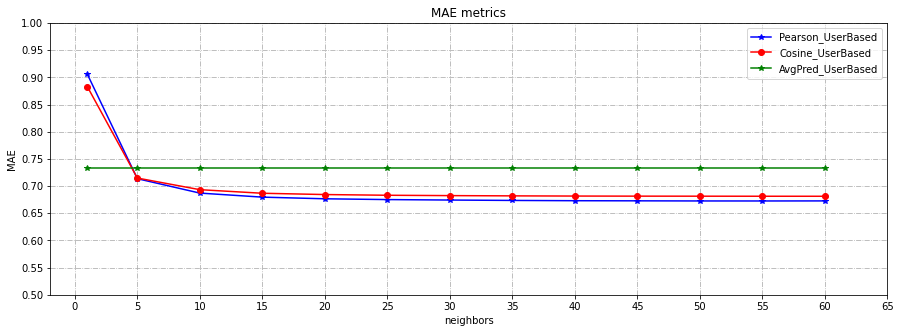

In [24]:
import matplotlib.pyplot as plt
import numpy as np
neighbor_num_list=[1,5,10,15,20,25,30,35,40,45,50,55,60]
"""1.MAE"""
Pearson_MAE_dict={1: 0.905860532685605, 5: 0.7136095232076057, 10: 0.6871015469966186, 15: 0.6796616293565697, 20: 0.6766173541699715, 25: 0.6751789713736132, 30: 0.6743102367826717, 35: 0.6735935554258159, 40: 0.6730747445829959, 45: 0.6728632677619419, 50: 0.6726300796028991, 55: 0.6726066597964483, 60: 0.6727273053236144}
Pearson_MAE_list=list(Pearson_MAE_dict.values())
Cosine_MAE_dict={1: 0.8829535718588655, 5: 0.7147809953775883, 10: 0.6933731408305048, 15: 0.686795031436491, 20: 0.6844139329085355, 25: 0.6831233962997183, 30: 0.6824646356203591, 35: 0.6819909957893222, 40: 0.6816481218712721, 45: 0.6814746765456592, 50: 0.68140166761427, 55: 0.6813001398377648, 60: 0.6812613169162768}
Cosine_MAE_list=list(Cosine_MAE_dict.values())
AvePred_MAE_dict={1: 0.7338536502317142, 5: 0.7338536502317142, 10: 0.7338536502317142, 15: 0.7338536502317142, 20: 0.7338536502317142, 25: 0.7338536502317142, 30: 0.7338536502317142, 35: 0.7338536502317142, 40: 0.7338536502317142, 45: 0.7338536502317142, 50: 0.7338536502317142, 55: 0.7338536502317142, 60: 0.7338536502317142}
AvePred_MAE_list=list(AvePred_MAE_dict.values())
"""2.RMSE"""
Cosine_RMSE_dict={1: 1.1451573063019385, 5: 0.924665027360477, 10: 0.9007486685475774, 15: 0.8941512517287828, 20: 0.8917179679165358, 25: 0.8906570022333711, 30: 0.8902009446936271, 35: 0.8899717894981396, 40: 0.8898713196013887, 45: 0.8898520553371874, 50: 0.8899419211145544, 55: 0.8899933088315464, 60: 0.890031898398601}


plt.figure(figsize=(15,5))
plt.plot(neighbor_num_list,Pearson_MAE_list,'b*-',label="Pearson_UserBased")
plt.plot(neighbor_num_list,Cosine_MAE_list,'ro-',label="Cosine_UserBased")
plt.plot(neighbor_num_list,AvePred_MAE_list,'g*-',label="AvgPred_UserBased")

plt.legend(loc="best")
plt.title('MAE metrics')
plt.xlabel('neighbors');
plt.ylabel('MAE')

#设置刻度
xtick_range=list(range(0,max(neighbor_num_list)+10,5))
plt.xticks(xtick_range, #标签的位置
           [str(i) for i in xtick_range] #str标签list
          )
y_bottom,y_top=0.5,1
ytick_range= np.arange(y_bottom,1.01,0.05)
plt.ylim((y_bottom,y_top)) #ylim((bottom, top)) 
plt.yticks(ytick_range,["{:.2f}".format(i) for i in ytick_range])

plt.grid(linestyle='-.',axis='both') 
plt.show()
